In [30]:
# Imports 
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import csv

# DUDC : discrete unit disc cover
## I) - DUDC dans $\mathbb{R} (d=1) $ 
### Question 01 : Algorithme glouton qui résout le DUDC:
#### Classes utilisées 

In [31]:
# Discrete Unit Disk Problem (DUDC)
# Used functions
def norm2(a,b):
    return (a.x-b.x)**2 + (a.y-b.y)**2

# Used Classes !
class Point:
    def __init__(self,x=0,y=0):
        self.x = x
        self.y=y

    def __repr__(self):
        return f'({self.x},{self.y})'

    def __lt__(self, other):
        return (self.x < other.x) or (self.x == other.x and self.y < other.y)

class Circle:
    def __init__(self,x,y,r=1):
        self.x=x
        self.y=y
        self.r=r

    def __repr__(self):
        return f'({self.x},{self.y})'

    def __lt__(self, other):
        return (self.x < other.x) or (self.x == other.x and self.y < other.y)

    def covers(self,point):
        return norm2(point,self) <= 1



## Classe DUDC qu'on va s'en servir pour la représentation graphique :

In [32]:
class DUDC:
    def __init__(self):
        self.P = set() # set of points
        self.Q = set() # set of unit circles
        self.num_P =self.num_Q= 0
        self.d = 1  # We are in |R

    def __repr__(self):
        return f'({self.P},{self.Q})'

    def figure(self,solution=[],original=True):
        plt.clf()
        plt.axis("equal")
        for p in self.P:
            plt.scatter(p.x,p.y,marker='o',c='k',zorder=2)
        for q in self.Q:
            color= 'red' if original or q not in solution else 'green'
            plt.scatter(q.x, q.y,marker = 's',c=color, zorder = 1,s=10)
            # Dans le cas ou on affiche les cercles sur R
            p1,p2=[q.x-1,q.x+1],[0,0]
            disc_1d=[p1,p2]
            # plt.plot(*disc_1d,color)
            circle = plt.Circle((q.x, q.y), 1,color = color, alpha = 0.1, zorder = 0)
            plt.gcf().gca().add_artist(circle)

        plt.xlabel('Abscisses X')
        plt.ylabel('Ordonnées Y')
        plt.title('DUDC Problem graph')
        return plt

    def parse_file(self,path):
        with open(path,'r') as f:
            d=list(csv.reader(f,delimiter=';'))    
            points=d[0]
            circles=d[1]
            

            for p in points:
                x,y=tuple(map(float,p.split(',')))
                point=Point(x,y)
                if y != float(0) : self.d=2
                self.P.add(point)
                self.num_P+=1
            print(f' Points Set : {self.P}')
            for c in circles:
                x,y=tuple(map(float,c.split(',')))
                circle=Circle(x,y)
                self.Q.add(circle)
                self.num_Q+=1
            print(f' Circles Set : {self.Q}')

# Algorithme Glouton (Greedy aproach) DUDC 1D

In [33]:
def dudc_1d(P,Q):
    # On Trie de gauche à droite les cercles et les points
    points=sorted(list(P))
    circles=sorted(list(Q))
    Q_star=set()
    while len(points):
        # On prend le premier cercle à gauche 
        p_left=points[0]

        # Le cercle plus à droite qui couvre ce point
        for i,c in enumerate(circles):
            if c.covers(p_left):
                candidat=circles[i]
        if not candidat:
            print(' Ce probleme n\'admet pas de solutions ')
            Q_star.clear()
            return
        
        # On supprime tout les points déjà dans le cercle candidat
        pts_restants=[p for p in points if not candidat.covers(p)]
        points=pts_restants  
        # On ajoute le cercle au résultat
        Q_star.add(candidat)
    
    return Q_star


# Test de l'algo DUDC

 Points Set : {(6.3,0.0), (5.0,0.0), (4.0,0.0), (8.0,0.0), (4.5,0.0)}
 Circles Set : {(3.0,0.0), (8.7,0.0), (5.6,0.0), (4.6,0.0), (7.2,0.0)}


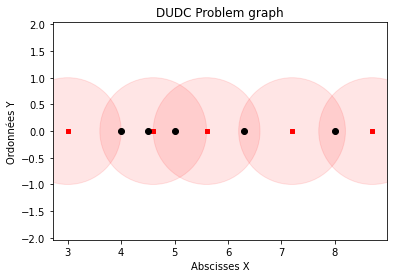

 Voila la solution :


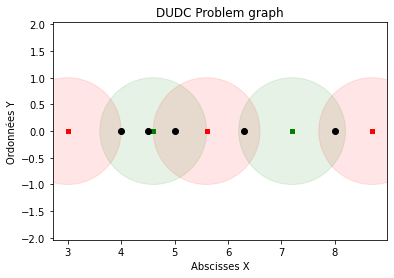

 Points Set : {(8.0,0.0), (6.3,0.0), (5.0,0.0), (4.5,0.0), (4.0,0.0)}
 Circles Set : {(7.2,0.3), (5.6,-0.2), (4.6,0.5), (9.0,0.1), (3.0,0.2)}


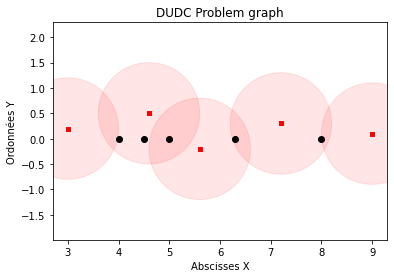

 Voila la solution :


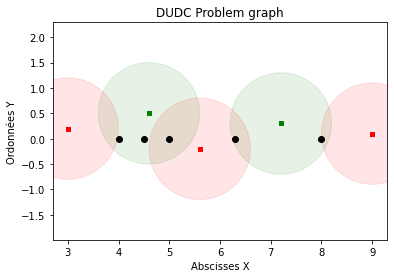

In [34]:
def dudc_test(dimension=1):
    in_path='DUDC_examples/1D' if dimension == 1 else 'DUDC_examples/2D'
    out_path= 'DUDC_out/1D' if dimension == 1 else 'DUDC_out/2D'
    
    files= os.listdir(in_path)

    for file in files:
        dudc=DUDC()
        dudc.parse_file(f'{in_path}/{file}')
        fig=dudc.figure()
        title=f'{file[:-4]}_origin.png'
        fig.savefig(f'{out_path}/{title}')
        fig.show()

        if dudc.d == 1:
            Q_star=dudc_1d(dudc.P,dudc.Q)
        else:
            Q_star=dudc_2d(dudc.P,dudc.Q)
        
        if len(Q_star):
            print(' Voila la solution :')
            res=dudc.figure(Q_star,False)
            title_after=f'{file[:-4]}_sol.png'
            res.savefig(f'{out_path}/{title_after}')
            res.show()
        else:
            print(' Ce probleme n\'admet pas de solution')

# On teste DUDC sur R
dudc_test(dimension=1)

# DUDC sur $\mathbb{R}^2$
### Classes utiles pour le Branch & Bound

In [35]:
class Node:
    def __init__(self,parent=None,left_child=None,right_child=None,
                 circle=None,LB=math.inf,taken_circles=[],
               explored_circles=[],rmg_points=[]):
        self.parent=parent
        self.left_child=left_child
        self.right_child=right_child
        self.circle=circle
        self.LB=LB
        self.parent=parent
        self.taken_circles=taken_circles
        self.explored_circles=explored_circles
        self.rmg_points=rmg_points

    def get_lb(self,circles):
        nb_rmg_pts=len(self.rmg_points)
        lb=len(self.taken_circles)

        for circle in circles:
            if circle not in self.taken_circles and \
               circle not in self.explored_circles:
                lb+=1
                nb_rmg_pts-=circle[1]
                if nb_rmg_pts <= 0 : break
        self.LB= math.inf if nb_rmg_pts > 0 else lb
    
    def branch(self,circle_next,circles):
        in_circles=[point for point in self.rmg_points
                    if not self.circle[0].covers(point)]
        self.left_child=Node(parent = self, circle = circle_next,
                             taken_circles = self.taken_circles + [self.circle],
                             explored_circles = self.explored_circles,
                             rmg_points = in_circles)
        self.left_child.get_lb(circles)
        self.right_child = Node(parent = self, circle = circle_next,
                                taken_circles = self.taken_circles,
                                explored_circles = self.explored_circles + [self.circle],
                                rmg_points = self.rmg_points)
        self.right_child.get_lb(circles=circles)
        

# Algorithme B&B de DUDC sur $\mathbb{R}^2$

In [36]:
def dudc_2d(P,Q):
    points,circles=P,Q
    Q_star=set()
    std_circles=[]
    for circle in circles:
        cpt=0
        for point in points:
            if circle.covers(point): cpt+=1
        std_circles.append([circle,cpt])
    std_circles.sort(key= lambda x:x[1],reverse=True)

    root=Node(circle=std_circles[0],rmg_points=list(points))
    root.get_lb(std_circles)
    if root.LB == math.inf:
        print(' Ce probleme n\'admet pas de solution')
        return Q_star

    next_visit=[root]
    sol_state=None

    while len(next_visit) > 0:
        node=min(next_visit,key=lambda x:x.LB)
        next_visit.remove(node)
        if len(node.rmg_points) == 0 :
            if sol_state is None or node.LB < sol_state.LB:
                sol_state=node
        if node.circle and len(node.rmg_points) > 0:
            idx=std_circles.index(node.circle)+1
            next_circle=std_circles[idx] if idx < len(std_circles) else None
            node.branch(next_circle,std_circles)
            
            if node.left_child.LB != math.inf:
               next_visit.append(node.left_child)
            if node.right_child.LB != math.inf:
               next_visit.append(node.right_child)
        
        if sol_state:
            for nd in next_visit:
                if nd.LB >= sol_state.LB:
                    next_visit.remove(nd)

    if not sol_state:
        print(' Ce probleme n\'admet pas de solution')
    else :
        for circle in sol_state.taken_circles:
            Q_star.add(circle[0])
    return Q_star


# Testons DUDC sur $\mathbb{R}^2$

 Points Set : {(6.3,0.3), (5.0,0.8), (8.0,0.1), (4.0,1.0), (4.5,-0.35)}
 Circles Set : {(3.0,0.2), (7.2,0.3), (9.0,0.1), (4.6,0.5), (5.6,-0.2)}


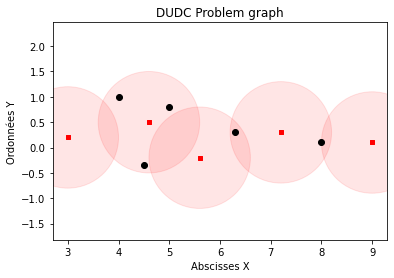

 Voila la solution :


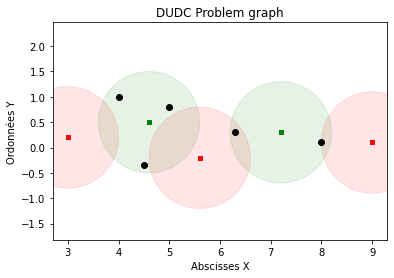

 Points Set : {(2.0,2.5), (4.0,0.9), (3.0,2.5), (0.8,0.8), (1.8,4.2), (2.4,2.1), (0.8,3.3)}
 Circles Set : {(4.0,1.5), (0.9,1.5), (1.4,3.9), (1.2,0.3), (2.5,2.5), (3.9,2.5)}


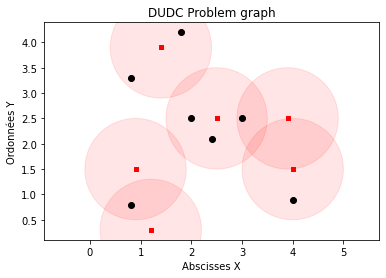

 Voila la solution :


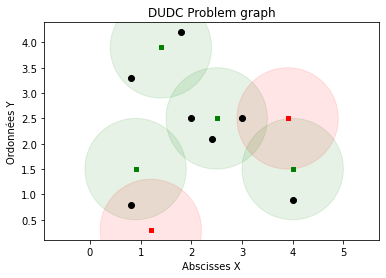

In [37]:
dudc_test(2)